In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

DELETION_TYPE = 'long'

In [2]:
import pandas as pd 
import numpy as np 

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

## Large windows with overlapping deletions and Chen scores

In [3]:
def read_large_windows():
  # experiments/germline-model/chen-et-al-2022/deletion-density.1.ipynb
  df = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-with-{DELETION_TYPE}-deletions-intersect-small-windows.aggregated.csv', 
    sep=',',
  )  
  return df 

read_large_windows() 

,chrom_large,start_large,end_large,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap,sum small_window overlaps merged_exon,sum small_window overlaps enhancer,sum small_window overlaps cpg_island,sum N_observed,sum enhancer count,sum small_window_enhancer_overlap_bps sum,sum N_mean_null_chen,sum N_variance_null_chen,sum large_window-small_window overlap,min negative new chen zscore,negative new chen zscore
0,chr1,2300000,2400000,4,60303,21,13,7,8177,14,9337,9794.714649,9794.714649,31000,-6.254506,-16.345794
1,chr1,2400000,2500000,2,74431,4,4,1,3093,4,1798,3866.251388,3866.251388,13000,-6.184123,-12.435855
2,chr1,2500000,2600000,1,2537,22,21,11,7172,24,17979,9340.543817,9340.543817,28000,-8.252822,-22.437895
3,chr1,2600000,2700000,3,37639,5,2,0,3669,2,1037,4376.598388,4376.598388,18000,-5.443687,-10.695928
4,chr1,2800000,2900000,6,63623,3,6,0,6183,6,2048,7225.712275,7225.712275,25000,-4.825689,-12.266599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24628,chr9,133900000,134000000,10,88278,3,25,3,7476,27,19573,9422.773366,9422.773366,32000,-5.783680,-20.055155
24629,chr9,134000000,134100000,2,100000,11,11,2,7910,12,6989,9103.134739,9103.134739,37000,-5.149057,-12.505297
24630,chr9,134200000,134300000,8,82201,5,25,0,10653,27,18569,13194.622097,13194.622097,47000,-5.052936,-22.126489
24631,chr9,134300000,134400000,0,0,1,18,2,5128,21,13587,6424.429486,6424.429486,22000,-6.073125,-16.174528


## Critical and noncritical genes

In [4]:
def read_critical_genes():
  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/genes/grch38/critical.genes.sorted.bed", 
    sep = '\t',
    header=None,
    names=['chrom', 'start', 'end', 'gene'],
  )  
  return df 

read_critical_genes().head()

,chrom,start,end,gene
0,chr1,6785454,7769706,CAMTA1
1,chr1,10210570,10381603,KIF1B
2,chr1,11012344,11030528,TARDBP
3,chr1,11273198,11296049,UBIAD1
4,chr1,11845709,11848345,NPPA


In [5]:
def read_noncritical_genes():
  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/genes/grch38/noncritical.genes.sorted.bed", 
    sep = '\t',
    header=None,
    names=['chrom', 'start', 'end', 'gene'],
  )  
  return df 

read_noncritical_genes().head()

,chrom,start,end,gene
0,chr1,65419,71585,OR4F5
1,chr1,450740,451678,OR4F29
2,chr1,685716,686654,OR4F16
3,chr1,923923,944575,SAMD11
4,chr1,944203,959309,NOC2L


## Compute number of critical and noncritical genes that overlap each large window


In [6]:
from shell import shell

# binary classification 
def compute_true_constraint(row): 
  if row['critical_gene_count'] > 0: 
    return True
  else: 
    return False
  
def intersect_large_windows_with_critical_and_noncritical_genes():
  large_windows_csv = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-with-{DELETION_TYPE}-deletions-intersect-small-windows.aggregated.csv'
  large_windows_with_critical_gene_counts = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-with-{DELETION_TYPE}-deletions-intersect-small-windows-with-gene-counts.bed'
  cmd = (
    f'bedtools intersect'
    f" -a <(python create_bed_file_of_large_windows.py {large_windows_csv})"
    f" -b" 
    f" {CONSTRAINT_TOOLS_DATA}/genes/grch38/critical.genes.sorted.bed"
    f" {CONSTRAINT_TOOLS_DATA}/genes/grch38/noncritical.genes.sorted.bed"
    f' -names critical noncritical'
    f' -C'
    f' -f 0.1'
    f' | sort -k1,1V -k2,2n'
    f' > {large_windows_with_critical_gene_counts}'
  )
  shell(cmd)

  with open(large_windows_csv) as f: 
    index = f.readline().strip().split(',')

  df = pd.read_csv(
    large_windows_with_critical_gene_counts, 
    sep='\t',
    names=index + ['gene_class', 'number_of_overlapping_genes'],
  )
  df = df.pivot(
    index=index, 
    columns='gene_class', 
    values='number_of_overlapping_genes'
  ) 
  df = df.rename(columns={'critical': 'critical_gene_count', 'noncritical': 'noncritical_gene_count'})
  df = df.reset_index()
  df = df.rename_axis('index', axis=1) # rename index column

  df['gene_counts'] = list(zip(df['critical_gene_count'], df['noncritical_gene_count']))
  
  print('gene counts (critical, noncritical) and number of windows')
  print(df['gene_counts'].value_counts())

  df['true_constraint'] = df.apply(compute_true_constraint, axis=1)

  return df 

LABELED_EXAMPLES = intersect_large_windows_with_critical_and_noncritical_genes()
LABELED_EXAMPLES


gene counts (critical, noncritical) and number of windows
(0, 1)     10021
(0, 0)      9404
(0, 2)      3045
(0, 3)       912
(1, 0)       625
(1, 1)       275
(0, 4)       174
(1, 2)        79
(0, 5)        33
(1, 3)        26
(2, 0)        10
(1, 4)         6
(2, 2)         5
(2, 1)         4
(0, 6)         4
(0, 7)         2
(0, 15)        2
(2, 3)         1
(0, 10)        1
(0, 13)        1
(0, 12)        1
(0, 22)        1
(1, 22)        1
Name: gene_counts, dtype: int64


index,chrom_large,start_large,end_large,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap,sum small_window overlaps merged_exon,sum small_window overlaps enhancer,sum small_window overlaps cpg_island,sum N_observed,sum enhancer count,sum small_window_enhancer_overlap_bps sum,sum N_mean_null_chen,sum N_variance_null_chen,sum large_window-small_window overlap,min negative new chen zscore,negative new chen zscore,critical_gene_count,noncritical_gene_count,gene_counts,true_constraint
0,chr1,2300000,2400000,4,60303,21,13,7,8177,14,9337,9794.714649,9794.714649,31000,-6.254506,-16.345794,0,2,"(0, 2)",False
1,chr1,2400000,2500000,2,74431,4,4,1,3093,4,1798,3866.251388,3866.251388,13000,-6.184123,-12.435855,0,1,"(0, 1)",False
2,chr1,2500000,2600000,1,2537,22,21,11,7172,24,17979,9340.543817,9340.543817,28000,-8.252822,-22.437895,0,1,"(0, 1)",False
3,chr1,2600000,2700000,3,37639,5,2,0,3669,2,1037,4376.598388,4376.598388,18000,-5.443687,-10.695928,0,2,"(0, 2)",False
4,chr1,2800000,2900000,6,63623,3,6,0,6183,6,2048,7225.712275,7225.712275,25000,-4.825689,-12.266599,0,0,"(0, 0)",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24628,chr9,133900000,134000000,10,88278,3,25,3,7476,27,19573,9422.773366,9422.773366,32000,-5.783680,-20.055155,0,1,"(0, 1)",False
24629,chr9,134000000,134100000,2,100000,11,11,2,7910,12,6989,9103.134739,9103.134739,37000,-5.149057,-12.505297,0,1,"(0, 1)",False
24630,chr9,134200000,134300000,8,82201,5,25,0,10653,27,18569,13194.622097,13194.622097,47000,-5.052936,-22.126489,0,0,"(0, 0)",False
24631,chr9,134300000,134400000,0,0,1,18,2,5128,21,13587,6424.429486,6424.429486,22000,-6.073125,-16.174528,0,1,"(0, 1)",False


## SNV-only, SV-only, and SNV+SV classifiers 

In [7]:
def predict_constraint_using_SNVs(df, zscore_threshold): 
  score = 'negative new chen zscore' # zscore = 'min negative new chen zscore' 
  df = df[[score, 'true_constraint']].copy()
  df['predicted to be constrained'] = df[score] < zscore_threshold
  return df

predict_constraint_using_SNVs(LABELED_EXAMPLES, zscore_threshold=-6)

index,negative new chen zscore,true_constraint,predicted to be constrained
0,-16.345794,False,True
1,-12.435855,False,True
2,-22.437895,False,True
3,-10.695928,False,True
4,-12.266599,False,True
...,...,...,...
24628,-20.055155,False,True
24629,-12.505297,False,True
24630,-22.126489,False,True
24631,-16.174528,False,True


In [8]:
def predict_constraint_using_SVs(df, deletion_count_threshold): 
  df = df[[
    'true_constraint', 
    'number_of_overlapping_topmed_deletions'
  ]].copy()
  df['predicted to be constrained'] = df['number_of_overlapping_topmed_deletions'] <= deletion_count_threshold
  return df

pd.set_option('display.max_rows', 10)

predict_constraint_using_SVs(LABELED_EXAMPLES, deletion_count_threshold=0)

index,true_constraint,number_of_overlapping_topmed_deletions,predicted to be constrained
0,False,4,False
1,False,2,False
2,False,1,False
3,False,3,False
4,False,6,False
...,...,...,...
24628,False,10,False
24629,False,2,False
24630,False,8,False
24631,False,0,True


In [9]:
def predict_constraint_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold): 
  zscore = 'negative new chen zscore' # zscore = 'min negative new chen zscore' 
  df = df[[
    zscore, 
    'true_constraint', 
    'number_of_overlapping_topmed_deletions'
  ]].copy()
  # majority voting ensemble (i.e. if both the SNV and SV model predict a region to be constrained, then it is predicted to be constrained)
  df['predicted to be constrained'] = (
    predict_constraint_using_SNVs(df, zscore_threshold)['predicted to be constrained'] & 
    predict_constraint_using_SVs(df, deletion_count_threshold)['predicted to be constrained']
  )
  # # "OR" ensemble (i.e. if either the SNV or SV model predicts a region to be constrained, then it is predicted to be constrained)
  # df['predicted to be constrained'] = (
  #   predict_constraint_using_SNVs(df, zscore_threshold)['predicted to be constrained'] |
  #   predict_constraint_using_SVs(df, deletion_count_threshold)['predicted to be constrained']
  # )
  return df 

pd.set_option('display.max_rows', 10)

predict_constraint_using_voting_ensemble(LABELED_EXAMPLES, zscore_threshold=-2, deletion_count_threshold=0)

index,negative new chen zscore,true_constraint,number_of_overlapping_topmed_deletions,predicted to be constrained
0,-16.345794,False,4,False
1,-12.435855,False,2,False
2,-22.437895,False,1,False
3,-10.695928,False,3,False
4,-12.266599,False,6,False
...,...,...,...,...
24628,-20.055155,False,10,False
24629,-12.505297,False,2,False
24630,-22.126489,False,8,False
24631,-16.174528,False,0,True


In [10]:
def compute_precision_recall(df, log): 
  contingency_table = pd.crosstab(
    df['predicted to be constrained'], 
    df['true_constraint']
  )

  if log: print(contingency_table)

  tp = contingency_table.loc[True, True]
  fp = contingency_table.loc[True, False]
  fn = contingency_table.loc[False, True]
  precision = tp / (tp + fp) # type: ignore
  recall = tp / (tp + fn) # type: ignore

  return precision, recall

def compute_precision_recall_using_SNVs(df, zscore_threshold, log=False): 
  if log: print(zscore_threshold)
  df = predict_constraint_using_SNVs(df, zscore_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_SNVs(LABELED_EXAMPLES, zscore_threshold=-3, log=True)

-3
true_constraint              False  True
predicted to be constrained             
False                        12992   384
True                         10609   648


(0.05756418228657724, 0.627906976744186)

In [11]:
def compute_precision_recall_using_SVs(df, deletion_count_threshold, log=False): 
  if log: print(deletion_count_threshold)
  df = predict_constraint_using_SVs(df, deletion_count_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_SVs(LABELED_EXAMPLES, deletion_count_threshold=0, log=True)

0
true_constraint              False  True
predicted to be constrained             
False                        21158   847
True                          2443   185


(0.07039573820395738, 0.17926356589147288)

In [12]:
def compute_precision_recall_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold, log=False): 
  if log: 
    print(zscore_threshold)
    print(deletion_count_threshold)
  df = predict_constraint_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold)
  return compute_precision_recall(df, log)
  
compute_precision_recall_using_voting_ensemble(LABELED_EXAMPLES, zscore_threshold=-3, deletion_count_threshold=0, log=True)

-3
0
true_constraint              False  True
predicted to be constrained             
False                        21928   898
True                          1673   134


(0.07415605976757056, 0.1298449612403101)

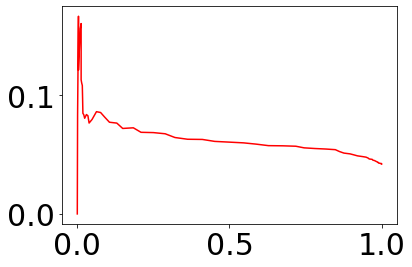

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30

def plot_precision_recall_using_SNVs(df): 
  zscore_thresholds = np.arange(-40, 40, 1) 
  precision_recall = [
    compute_precision_recall_using_SNVs(df, zscore_threshold, log=False)
    for zscore_threshold in zscore_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SNVs', color='red')

plot_precision_recall_using_SNVs(LABELED_EXAMPLES)

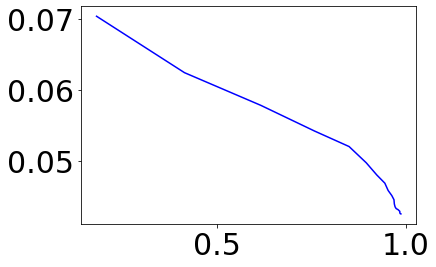

In [14]:
def plot_precision_recall_using_SVs(df): 
  deletion_count_thresholds = np.arange(0, 20, 1)
  precision_recall = [
    compute_precision_recall_using_SVs(df, deletion_count_threshold, log=False)
    for deletion_count_threshold in deletion_count_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  plt.plot(recalls, precisions, label='using SVs', color='blue')

plot_precision_recall_using_SVs(LABELED_EXAMPLES)

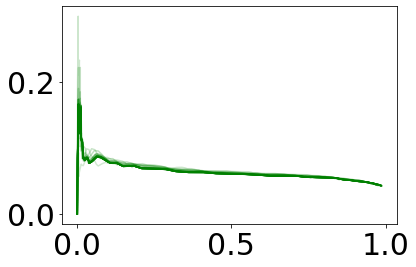

In [15]:
def plot_precision_recall_using_voting_ensemble(df): 
  zscore_thresholds = np.arange(-40, 40, 1) 
  deletion_count_thresholds = np.arange(0, 20, 1)
  alphas = np.logspace(-0.75, 0, len(deletion_count_thresholds))
  for index, (alpha, deletion_count_threshold) in enumerate(zip(alphas, deletion_count_thresholds)):
    precision_recall = [
      compute_precision_recall_using_voting_ensemble(df, zscore_threshold, deletion_count_threshold, log=False)
      for zscore_threshold in zscore_thresholds
    ]
    precisions, recalls = zip(*precision_recall)
    if index == 0 or index == len(deletion_count_thresholds) - 1: 
      plt.plot(recalls, precisions, label=f'using SNVs and SVs (majority-vote ensemble)\n(deletion-count threshold = {deletion_count_thresholds[index]})', color='green', alpha=alpha)
    else:
      plt.plot(recalls, precisions, color='green', alpha=alpha)

plot_precision_recall_using_voting_ensemble(LABELED_EXAMPLES)

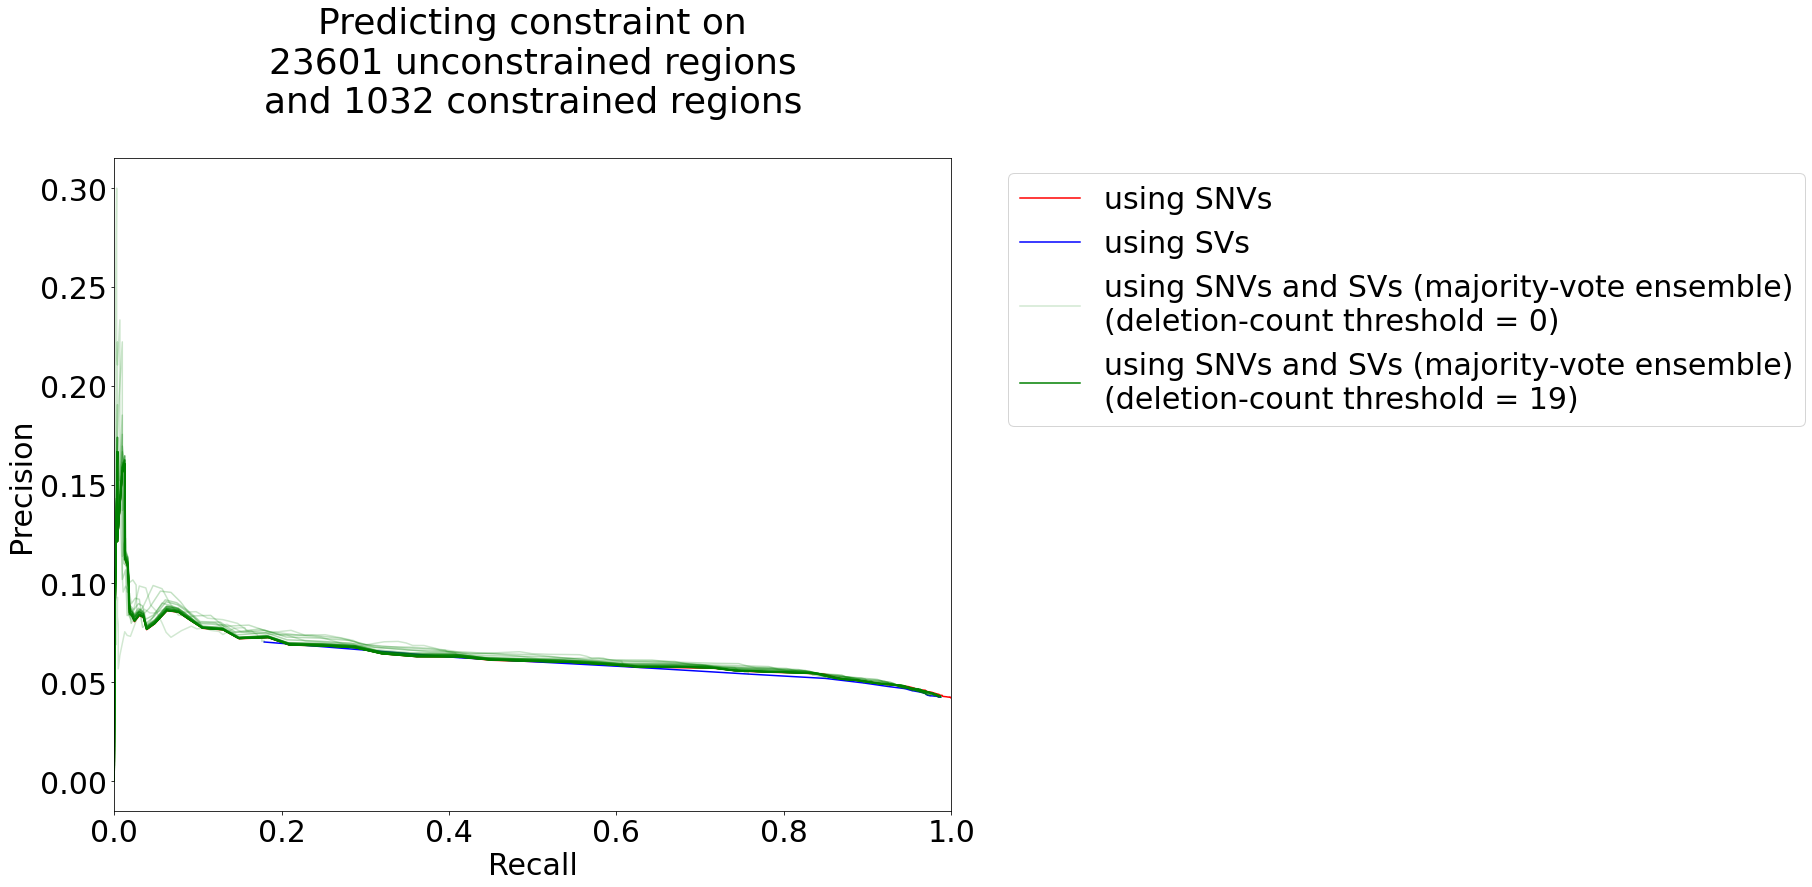

In [16]:
def plot_precision_recall_wrapper(df): 
  plot_precision_recall_using_SNVs(df)
  plot_precision_recall_using_SVs(df)
  plot_precision_recall_using_voting_ensemble(df)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  fig = plt.gcf()
  fig.set_size_inches(15, 12)
  plt.xlim(0, 1)
  # plt.ylim(0, 1)

  number_unconstrained_regions = df['true_constraint'].value_counts().loc[False]
  number_constrained_regions = df['true_constraint'].value_counts().loc[True]
  plt.title(
    'Predicting constraint on\n'
    f'{number_unconstrained_regions} unconstrained regions\n'
    f'and {number_constrained_regions} constrained regions\n'
  )
  
plot_precision_recall_wrapper(LABELED_EXAMPLES)